In [1]:
# Get all the modules into our path.
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')

# Import machine learning modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
import analysis as ana
from analysis import helper as hp

# Import data processing modules.
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

# Import some extra modules
import re

# Import data visualisation modules.
import matplotlib.pyplot as plt

In [2]:
# Port in and unpack all the runs we need from the .pkl file.
TrainSet_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/completed_run.pkl')

In [4]:
# Filter all errored files out of the dictionary
dataset_dict, error_dict = hp.filter_errors(TrainSet_dict)

Returned 13708 files without errors out of a total possible 16000.
2292 files had errors.
0 files had unhandled errors.
File failure rate: 16.72016340822877 %.
To see unhandled errors, run with verbose=True.


In [5]:
# Get a df of all the start attributes of interest
attributes_all_df = attr.get_condition(dataset_dict,"f_i_onehundred",species_concs=True)
attribute_names = ["Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)","Cl-"]
attributes_all_df = attributes_all_df.loc[:, attribute_names]
attributes_all_df

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,Al+++,Ca++,Fe++,K+,Na+,Mg++,SiO2(aq),Cl-
0,0.002374,0.019826,0.017537,0.014785,0.018126,0.010532,0.007219,0.019672
1,0.008444,0.003412,0.000822,0.012623,0.008231,0.005945,0.002997,0.004668
2,0.012336,0.012668,0.000941,0.013856,0.002694,0.007344,0.002040,0.006828
3,0.000130,0.011472,0.006773,0.005565,0.016614,0.011214,0.017162,0.014752
4,0.016216,0.000681,0.012435,0.003009,0.000893,0.007925,0.013076,0.004274
...,...,...,...,...,...,...,...,...
13703,0.018860,0.005502,0.013237,0.011360,0.007719,0.015144,0.003768,0.007280
13704,0.016937,0.011561,0.008638,0.000025,0.015434,0.019234,0.016235,0.015166
13705,0.017674,0.017780,0.010301,0.017664,0.019974,0.015528,0.008626,0.012389
13706,0.004736,0.007681,0.008406,0.016805,0.014606,0.001142,0.009619,0.010466


In [6]:
# Get an array of the end carbonate volumes generated
NonCalSidMag_arr = ["Diopside","Diopside_a","Hedenbergite","Hedenbergite_a",
                    "Albite","Albite_a","Anorthite","Anorthite_a","M_Microcline",
                    "M_Microcline_a","M_Microcline_b","Forsterite","Forsterite_a",
                    "Fayalite","Fayalite_a","Antigorite","Antigorite_a","Greenalite",
                    "Greenalite_a","Calcite_a","Siderite_a","Magnesite_a"]
CalSidMag_arr = ["Calcite","Siderite","Magnesite"]

Vols_ds = lbls.raw(dataset_dict, 'volume')
NrXDiscretisedBlocks = len(Vols_ds.X.values)
EndVols_ds = Vols_ds.sel(time=280.0)
CalSidMagEndVols_ds = EndVols_ds.drop(labels=NonCalSidMag_arr)

CalSidMagEndVols_da = CalSidMagEndVols_ds.to_array(dim='arbitrary_array')
CalSidMagEndVols_da = CalSidMagEndVols_da.astype(str)
CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+-\d+$", "0", regex=True)
CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+\+\d+$", "5000.0000", regex=True)
CalSidMagEndVols_da = CalSidMagEndVols_da.astype(float)

CalSidMagEndVols_ds = CalSidMagEndVols_da.to_dataset(dim="arbitrary_array")
SpatialSummedCalSidMagEndVols_ds = CalSidMagEndVols_ds.sum(dim=["X","Y","Z"])
SpatialSummedCarbEndVols_ds = SpatialSummedCalSidMagEndVols_ds.assign(Carbonates=lambda SpatialSummedCalSidMagEndVols_ds: SpatialSummedCalSidMagEndVols_ds.Calcite + SpatialSummedCalSidMagEndVols_ds.Siderite + SpatialSummedCalSidMagEndVols_ds.Magnesite)
# SpatialSummedCarbEndVols_ds = SpatialSummedCarbEndVols_ds.drop(labels=CalSidMag_arr)
SpatialSummedCalEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Calcite.values)
SpatialSummedSidEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Siderite.values)
SpatialSummedMagEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Magnesite.values)
SpatialSummedCarbEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Carbonates.values)

In [7]:
attributes_all_df["Calcite_sum"] = SpatialSummedCalEndVols_arr.tolist()
attributes_all_df["Siderite_sum"] = SpatialSummedSidEndVols_arr.tolist()
attributes_all_df["Magnesite_sum"] = SpatialSummedMagEndVols_arr.tolist()
attributes_all_df["Carbonates_sum"] = SpatialSummedCarbEndVols_arr.tolist()
attributes_all_df

,Al+++,Ca++,Fe++,K+,Na+,Mg++,SiO2(aq),Cl-,Calcite_sum,Siderite_sum,Magnesite_sum,Carbonates_sum
0,0.002374,0.019826,0.017537,0.014785,0.018126,0.010532,0.007219,0.019672,1.779112,2.323937e-06,1.751952e-08,1.779114
1,0.008444,0.003412,0.000822,0.012623,0.008231,0.005945,0.002997,0.004668,2.199260,9.683027e-06,2.071786e-08,2.199270
2,0.012336,0.012668,0.000941,0.013856,0.002694,0.007344,0.002040,0.006828,2.339171,1.965861e-05,2.143087e-08,2.339190
3,0.000130,0.011472,0.006773,0.005565,0.016614,0.011214,0.017162,0.014752,3.317894,1.263667e-05,1.994172e-08,3.317907
4,0.016216,0.000681,0.012435,0.003009,0.000893,0.007925,0.013076,0.004274,1.367511,7.427341e-07,1.454754e-08,1.367512
...,...,...,...,...,...,...,...,...,...,...,...,...
13703,0.018860,0.005502,0.013237,0.011360,0.007719,0.015144,0.003768,0.007280,2.091797,2.424698e-03,3.028562e-08,2.094221
13704,0.016937,0.011561,0.008638,0.000025,0.015434,0.019234,0.016235,0.015166,1.007418,3.786427e-07,6.468830e-08,1.007418
13705,0.017674,0.017780,0.010301,0.017664,0.019974,0.015528,0.008626,0.012389,1.324024,3.749947e-06,1.973235e-08,1.324028
13706,0.004736,0.007681,0.008406,0.016805,0.014606,0.001142,0.009619,0.010466,1.588487,1.173920e-06,1.644187e-08,1.588488


In [8]:
attributes_cleaned_df = attributes_all_df
attributes_cleaned_df.loc[attributes_cleaned_df['Calcite_sum'] > (1*NrXDiscretisedBlocks), 'Calcite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Siderite_sum'] > (1*NrXDiscretisedBlocks), 'Siderite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Magnesite_sum'] > (1*NrXDiscretisedBlocks), 'Magnesite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Carbonates_sum'] > (1*NrXDiscretisedBlocks), 'Carbonates_sum'] = np.nan

attributes_cleaned_df.loc[attributes_cleaned_df['Calcite_sum'] == np.inf, 'Calcite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Siderite_sum'] == np.inf, 'Siderite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Magnesite_sum'] == np.inf, 'Magnesite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Carbonates_sum'] == np.inf, 'Carbonates_sum'] = np.nan

attributes_cleaned_df = attributes_cleaned_df.dropna()
attributes_cleaned_df = attributes_cleaned_df.reset_index(drop=True)

attributes_cleaned_df["Calcite_avg"] = (attributes_cleaned_df["Calcite_sum"] / NrXDiscretisedBlocks)
attributes_cleaned_df["Siderite_avg"] = (attributes_cleaned_df["Siderite_sum"] / NrXDiscretisedBlocks)
attributes_cleaned_df["Magnesite_avg"] = (attributes_cleaned_df["Magnesite_sum"] / NrXDiscretisedBlocks)
attributes_cleaned_df["Carbonates_avg"] = (attributes_cleaned_df["Carbonates_sum"] / NrXDiscretisedBlocks)
attributes_cleaned_df = attributes_cleaned_df.drop(['Calcite_sum', 'Siderite_sum', 'Magnesite_sum', 'Carbonates_sum'], axis=1)

attributes_cleaned_df["Calcite_pct"] = (attributes_cleaned_df["Calcite_avg"] / 1) * 100
attributes_cleaned_df["Siderite_pct"] = (attributes_cleaned_df["Siderite_avg"] / 1) * 100
attributes_cleaned_df["Magnesite_pct"] = (attributes_cleaned_df["Magnesite_avg"] / 1) * 100
attributes_cleaned_df["Carbonates_pct"] = (attributes_cleaned_df["Carbonates_avg"] / 1) * 100
attributes_cleaned_df = attributes_cleaned_df.drop(['Calcite_avg', 'Siderite_avg', 'Magnesite_avg', 'Carbonates_avg'], axis=1)
attributes_cleaned_df

,Al+++,Ca++,Fe++,K+,Na+,Mg++,SiO2(aq),Cl-,Calcite_pct,Siderite_pct,Magnesite_pct,Carbonates_pct
0,0.002374,0.019826,0.017537,0.014785,0.018126,0.010532,0.007219,0.019672,1.170468,1.528906e-06,1.152600e-08,1.170470
1,0.008444,0.003412,0.000822,0.012623,0.008231,0.005945,0.002997,0.004668,1.446882,6.370412e-06,1.363017e-08,1.446888
2,0.012336,0.012668,0.000941,0.013856,0.002694,0.007344,0.002040,0.006828,1.538928,1.293329e-05,1.409925e-08,1.538941
3,0.000130,0.011472,0.006773,0.005565,0.016614,0.011214,0.017162,0.014752,2.182825,8.313598e-06,1.311955e-08,2.182833
4,0.016216,0.000681,0.012435,0.003009,0.000893,0.007925,0.013076,0.004274,0.899678,4.886409e-07,9.570748e-09,0.899679
...,...,...,...,...,...,...,...,...,...,...,...,...
13689,0.018860,0.005502,0.013237,0.011360,0.007719,0.015144,0.003768,0.007280,1.376182,1.595196e-03,1.992475e-08,1.377777
13690,0.016937,0.011561,0.008638,0.000025,0.015434,0.019234,0.016235,0.015166,0.662775,2.491071e-07,4.255809e-08,0.662775
13691,0.017674,0.017780,0.010301,0.017664,0.019974,0.015528,0.008626,0.012389,0.871068,2.467071e-06,1.298181e-08,0.871071
13692,0.004736,0.007681,0.008406,0.016805,0.014606,0.001142,0.009619,0.010466,1.045057,7.723157e-07,1.081702e-08,1.045058


['Al+++', 'Ca++', 'Fe++', 'K+', 'Na+', 'Mg++', 'SiO2(aq)', 'Cl-']


Text(0, 0.5, 'Tot. Carbonates Percentage Vol. Frac. Increase (%)')

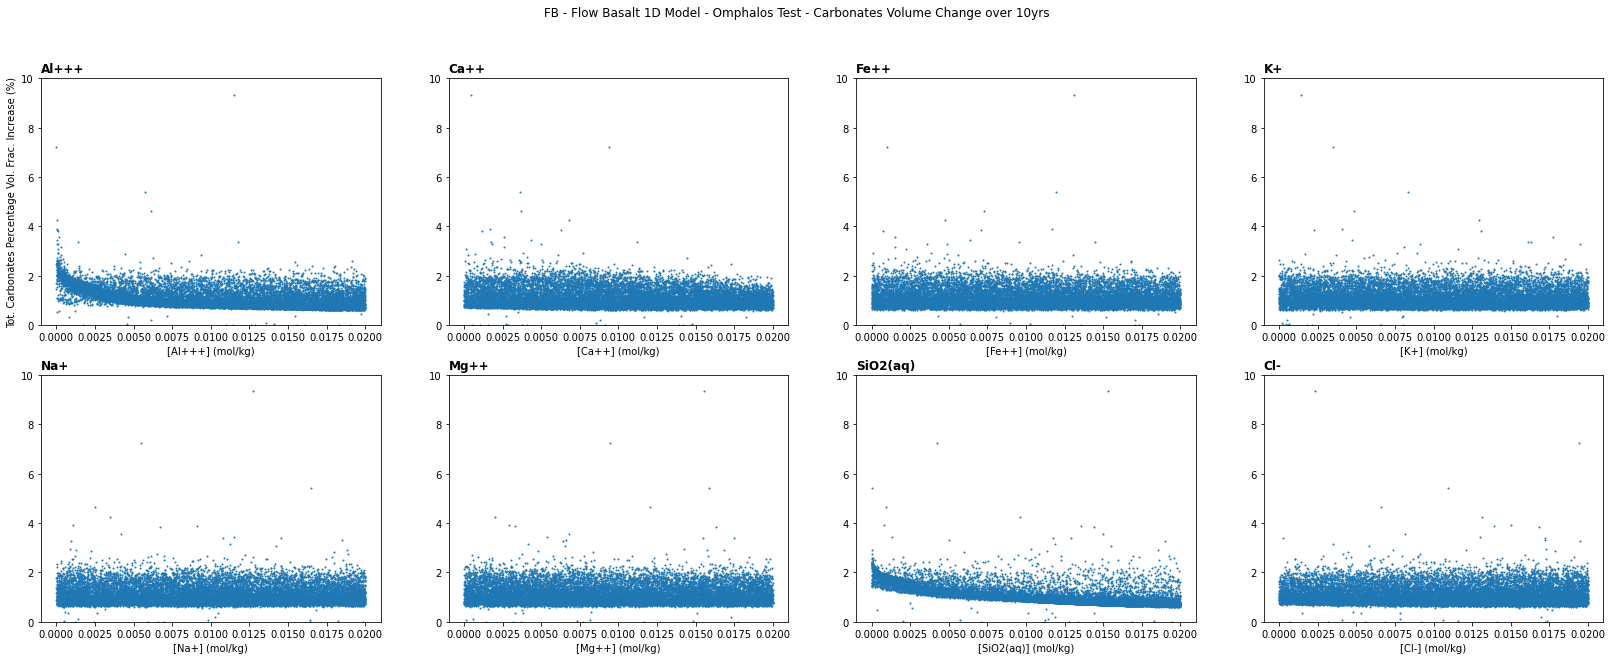

In [9]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Carbonates Volume Change over 10yrs')

fig.set_figheight(10)
fig.set_figwidth(28)

print(attribute_names)

for attribute_name,axis in zip(attribute_names,axes):
    axis.set_title(attribute_name, loc='left',fontweight="bold")
    x = attributes_cleaned_df[attribute_name].values
    y = attributes_cleaned_df.Carbonates_pct.values
    axis.scatter(x=x, y=y, s=1, alpha=1)
    axis.set_xlabel(f'[{attribute_name}] (mol/kg)')
    axis.set_ylim(0, 10)

ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')

Text(0, 0.5, 'Tot. Carbonates Percentage Vol. Frac. Increase (%)')

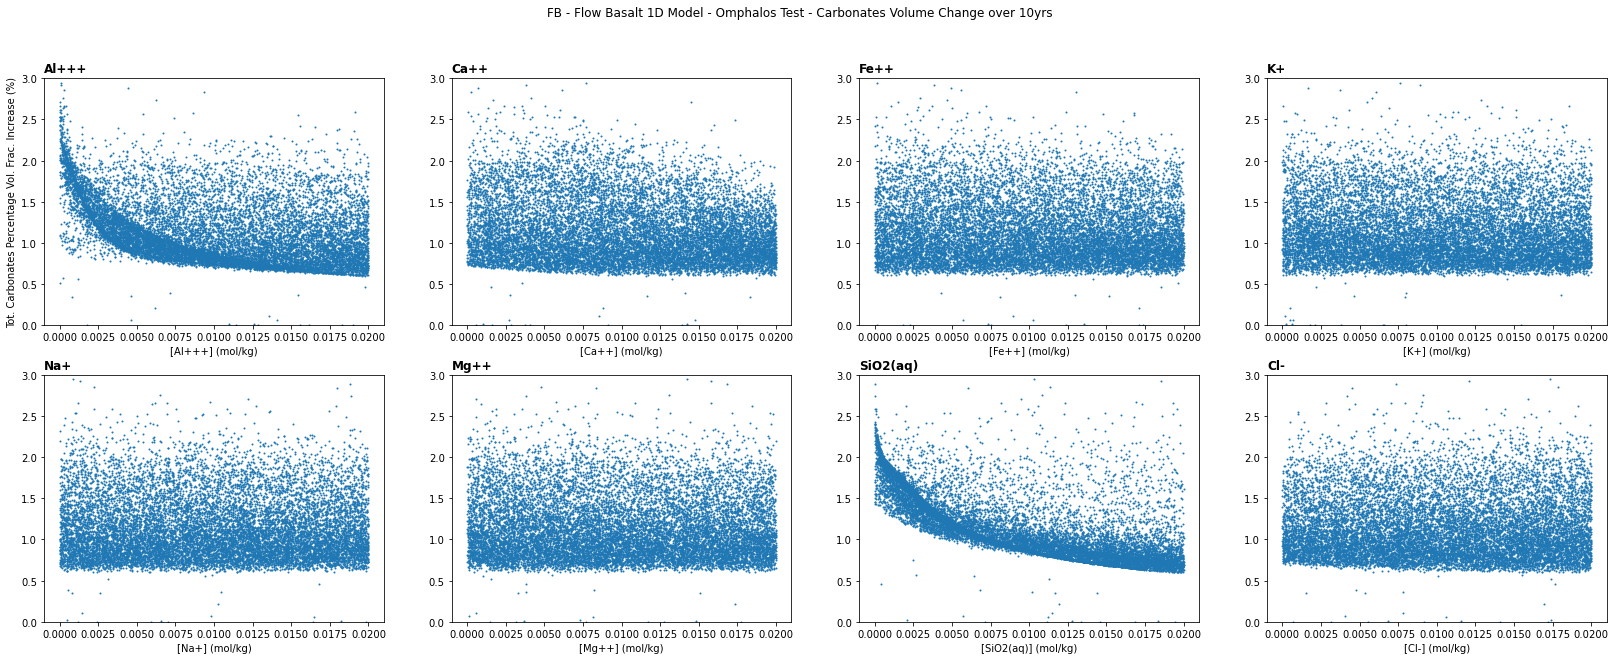

In [10]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Carbonates Volume Change over 10yrs')

fig.set_figheight(10)
fig.set_figwidth(28)

for attribute_name,axis in zip(attribute_names,axes):
    axis.set_title(attribute_name, loc='left',fontweight="bold")
    x = attributes_cleaned_df[attribute_name].values
    y = attributes_cleaned_df.Carbonates_pct.values
    axis.scatter(x=x, y=y, s=1, alpha=1)
    axis.set_xlabel(f'[{attribute_name}] (mol/kg)')
    axis.set_ylim(0, 3)

ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')

Text(0, 0.5, 'Tot. Calcite Percentage Vol. Frac. Increase (%)')

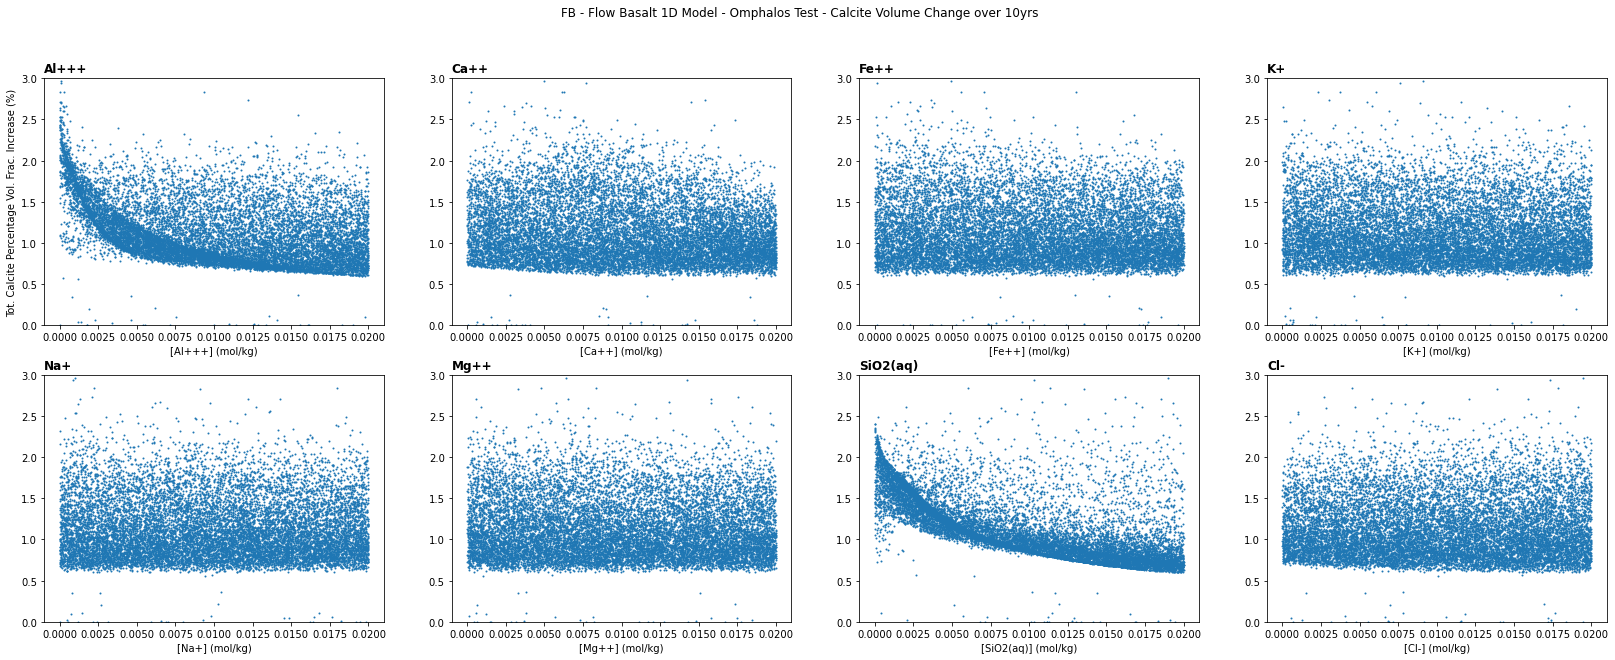

In [11]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Calcite Volume Change over 10yrs')

fig.set_figheight(10)
fig.set_figwidth(28)

for attribute_name,axis in zip(attribute_names,axes):
    axis.set_title(attribute_name, loc='left',fontweight="bold")
    x = attributes_cleaned_df[attribute_name].values
    y = attributes_cleaned_df.Calcite_pct.values
    axis.scatter(x=x, y=y, s=1, alpha=1)
    axis.set_xlabel(f'[{attribute_name}] (mol/kg)')
    axis.set_ylim(0, 3)

ax1.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')

Text(0, 0.5, 'Tot. Siderite Percentage Vol. Frac. Increase (%)')

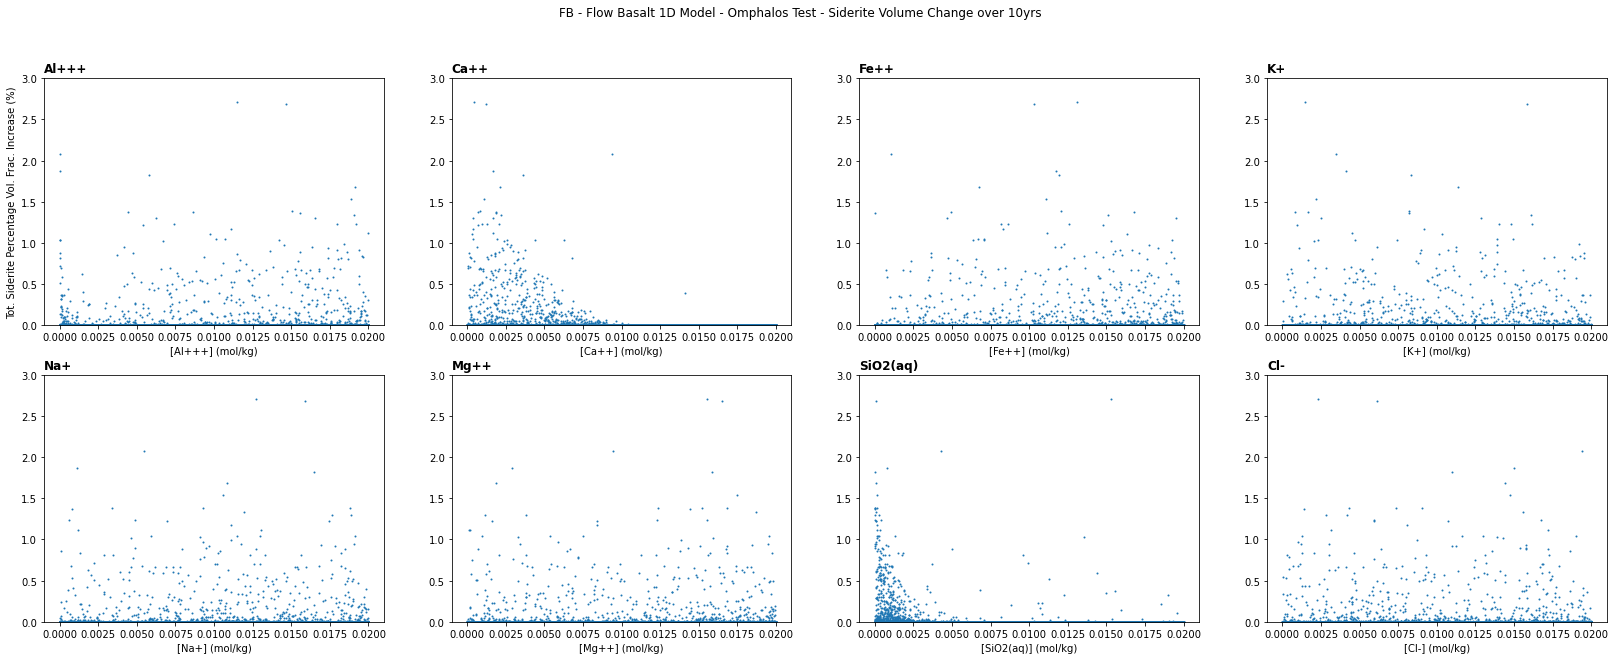

In [12]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Siderite Volume Change over 10yrs')

fig.set_figheight(10)
fig.set_figwidth(28)

for attribute_name,axis in zip(attribute_names,axes):
    axis.set_title(attribute_name, loc='left',fontweight="bold")
    x = attributes_cleaned_df[attribute_name].values
    y = attributes_cleaned_df.Siderite_pct.values
    axis.scatter(x=x, y=y, s=1, alpha=1)
    axis.set_xlabel(f'[{attribute_name}] (mol/kg)')
    axis.set_ylim(0, 3)

ax1.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')

Text(0, 0.5, 'Tot. Magnesite Percentage Vol. Frac. Increase (%)')

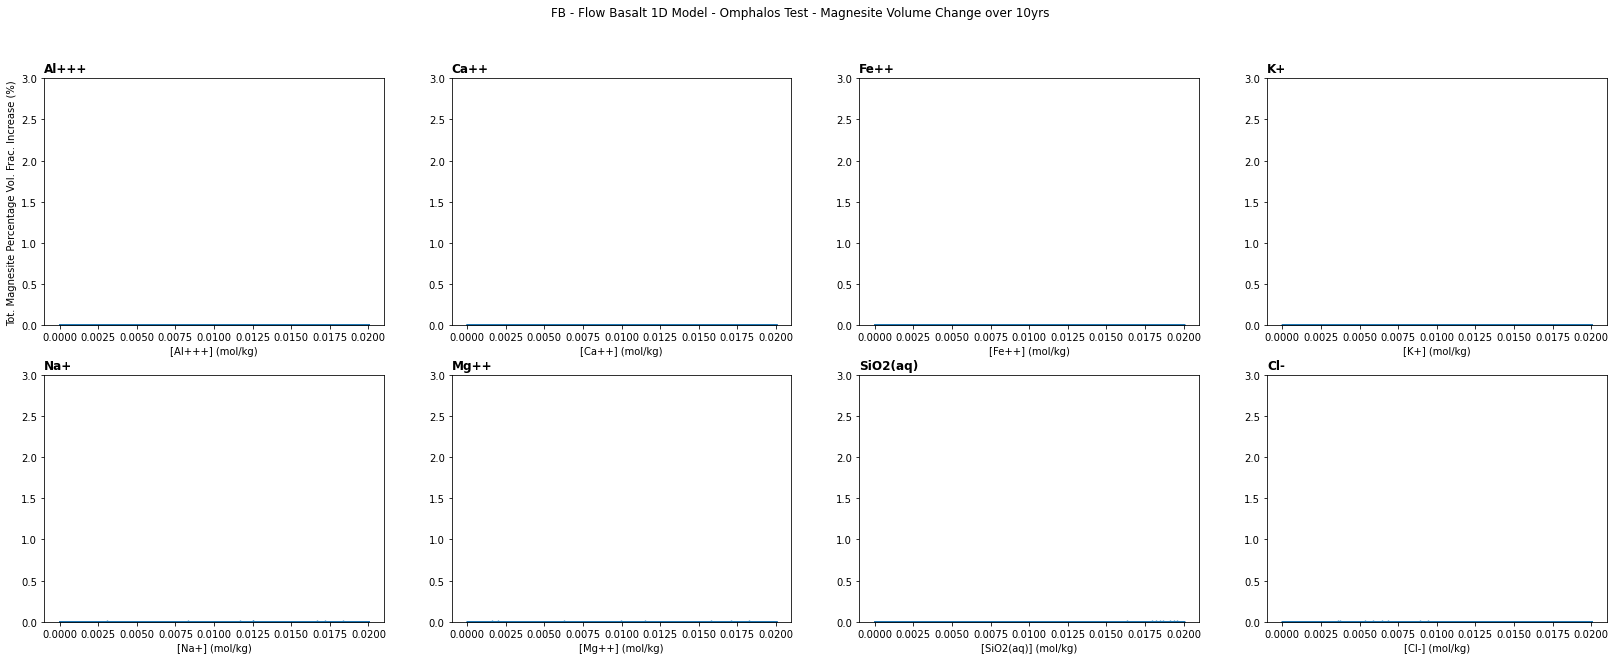

In [13]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Magnesite Volume Change over 10yrs')

fig.set_figheight(10)
fig.set_figwidth(28)

for attribute_name,axis in zip(attribute_names,axes):
    axis.set_title(attribute_name, loc='left',fontweight="bold")
    x = attributes_cleaned_df[attribute_name].values
    y = attributes_cleaned_df.Magnesite_pct.values
    axis.scatter(x=x, y=y, s=1, alpha=1)
    axis.set_xlabel(f'[{attribute_name}] (mol/kg)')
    axis.set_ylim(0, 3)

ax1.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')